# GPcounts Regression on synthetic data

Nuha BinTayyash, 2020

GPcounts is Gaussain process regression package for count data with negative binomial and zero-inflated negative binomial likelihoods described in the paper "Gaussian process modelling of count data with
application to bulk and single-cell RNA-Seq".

This notebook shows how to build a GPcount model and plot the posterior model fit on synthetic data.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.stats as ss
import gpflow
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


### Sample synthetic count data from Gaussian Process with negative binomial likelihood

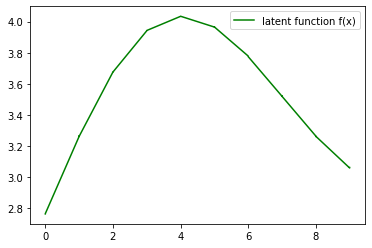

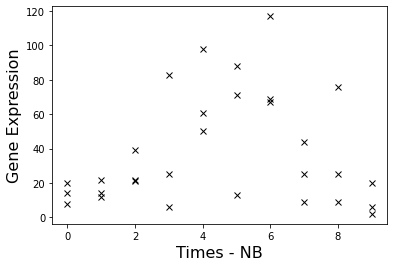

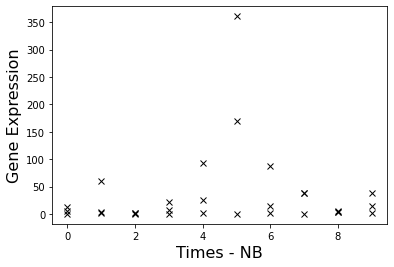

In [2]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(0)
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

def sample_GP():
    kern =  gpflow.kernels.RBF( lengthscales = 4.,variance = 1.) 
    K = kern(x) + np.eye(N) * 1e-6
    L = np.linalg.cholesky(K)  
    mu = np.ones((N, 1)) 
    f = np.dot(L, np.random.randn(N, 1)) + mu
    plt.plot(x, f,color= 'green',label = 'latent function f(x)')
    plt.legend()
    plt.show()
    return f

def sample_from_NegativeBinom(r,mean):
    # r  number of failures
    # prob probability of success
    prob = r/(mean+r)
    y =[]
    for i in range(mean.shape[0]):
        y.append(ss.nbinom.rvs(r, prob[i], size=1))
    y = np.vstack(y)    
    return y

N = 30  # cell
D = 2  # genes 
S = 3 # Samples 
x = np.array([0.,1.,2.,3.,4.,5.,6.,7.,8.,9.])
x = np.repeat(x, S).reshape(-1, 1)
f = sample_GP() 
link_f = np.exp(f)
alphas = [.5,3.]
y = []

for i in range(D):
    
    y.append(sample_from_NegativeBinom(1./alphas[i],link_f)[: None])
    plt.plot(x, y[i],'kx')
    plt.xlabel('Times - NB', fontsize=16)
    plt.ylabel('Gene Expression', fontsize=16)
    plt.show()

##### Create dataframes for gene expression count data and pseudotime points

In [3]:
y = np.array(y)
y = y.reshape(y.shape[0],y.shape[1])
genes_name = ['gene_%s' % (s+1) for s in range(y.shape[0])] 
cells_name = ['cell_%s' % (s+1) for s in range(y.shape[1])] 
Y = pd.DataFrame(data= y,index= genes_name,columns= cells_name) # gene expression count data
X = pd.DataFrame.from_dict({i: j for i, j in enumerate(x)}, orient='index',columns=['time_point'])

### Fit GPcounts

The avaliable likelihoods are: Negative_binomial, Zero_inflated_negative_binomial, Poisson and Gaussian.  

### Infre trajectory with RBF kernel

In [4]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial'  
gp_counts = Fit_GPcounts(X,Y) 
results = gp_counts.Infer_trajectory(likelihood)
results['likelihood']

100%|██████████| 2/2 [00:07<00:00,  3.66s/it]


,Dynamic_model_log_likelihood
gene_1,-137.063277
gene_2,-124.658433


##### save genes log likelihood 

In [5]:
results['likelihood'].to_csv("log_likelihood.csv")

In [6]:
results['fail']

[]

## Plot GPcounts fitting 

Load GPmodels models for selected genes and plot samples from the posterior predictive with negative binomial distribution or any selected distribution

In [7]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot():
    plt.tick_params(labelsize='large', width=2)     
    plt.ylabel('Gene Expression', fontsize=16)
    plt.xlabel('Times', fontsize=16)
    c = 'royalblue'
    
    if model_index == 3:
        c = 'green'
    
    plt.plot(xtest, mean,color= c, lw=2) 
    
    if likelihood == 'Gaussian':
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]),color=c,alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color=c, alpha=0.1)# two standard deviation
    else:
       
        lowess = sm.nonparametric.lowess    
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_16 = [(i > 0) * i for i in percentile_16]
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = [(i > 0) * i for i in percentile_84]
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,color=c,alpha=0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_5 = [(i > 0) * i for i in percentile_5]
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = [(i > 0) * i for i in percentile_95]
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color=c,alpha=0.1)
    
    if test == 'Two_samples_test' and model_index == 1:
        plt.scatter(model.data[0][0:int(model.data[0].shape[0]/2)],model.data[1][0:int(model.data[0].shape[0]/2)], s=30, marker='o', color= 'royalblue',alpha=1.) #data    
        plt.scatter(model.data[0][int(model.data[0].shape[0]/2)::],model.data[1][int(model.data[0].shape[0]/2)::], s=30, marker='o', color= 'green',alpha=1.) #data

    else: 
        plt.scatter(model.data[0],model.data[1],s=30,marker = 'o',color=c,alpha=1.)
    
    
    if not(test == 'Two_samples_test' and model_index == 2):
        plt.show()
    

100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


gene_1


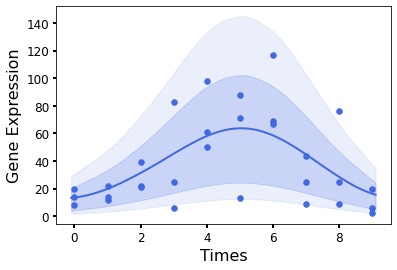

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,6.916844076641553
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,5.764279830516285
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.4316494860360618
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.45942888e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.16207517e-01, 0.00000000e+00, 0.00000000e+00..."


gene_2


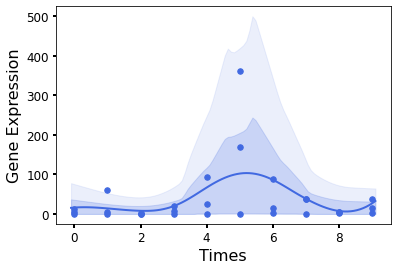

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,7.651386982297968
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.0550564225176418
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,2.4387554564495826
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[8.77537503e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[3.01109051e-01, 0.00000000e+00, 0.00000000e+00..."


In [8]:
indexes = Y.index.values # list of genes to be plotted 
test = 'Infer_trajectory' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')

In [10]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
gp_counts = Fit_GPcounts(X,Y,sparse = True) 
results = gp_counts.Infer_trajectory(likelihood)
results['likelihood']

100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


,Dynamic_model_log_likelihood
gene_1,-137.262387
gene_2,-123.821737


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

gene_1


AttributeError: 'SVGP' object has no attribute 'data'

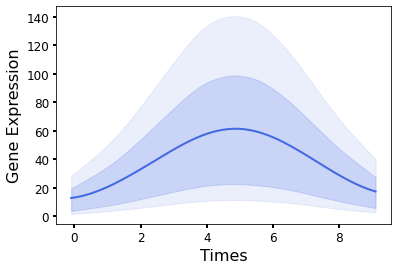

In [11]:
indexes = Y.index.values # list of genes to be plotted 
test = 'Infer_trajectory' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')